# Renewable Energy Forecasting

### Introduction
The project involves developing machine learning models to forecast solar and wind energy production, focusing on improving the reliability and efficiency of renewable energy sources. This project aims to address the challenge of intermittent energy production, a
critical issue in the integration of renewable energy into the power grid.

In [579]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
# Set options for displaying dataframes and figures
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf


Downlaod Data from https://www.kaggle.com/datasets/henriupton/wind-solar-electricity-production/data

Analysis with the help of :

https://www.kaggle.com/code/farshadj101/analysis-of-wind-and-solar-energy-production-trend

https://www.kaggle.com/code/nisargbhatt/wind-and-solar-production-and-analysis

https://www.kaggle.com/code/meeraajayakumar/predicting-power-production-using-regression/notebook

https://www.kaggle.com/code/sohaibmoradi/electricity-production-analysis-and-prediction

In [580]:
# Import data
df = pd.read_csv('/Users/moni/DS - Karan/Week6/Data/intermittent-renewables-production-france.csv', parse_dates=["Date"])
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


### About Dataset
This dataset consists of wind 💨 and solar ☀️ energy production (in MW)⚡️ records on an hourly basis for the French grid since 2020. Its primary purpose is to enable the Commission de Régulation de l'Énergie (CRE) to calculate the reference price used in the calculation of additional remuneration for the wind and solar sectors.

## Data cleaning and pre-processing

In [581]:
# Check the shape of the data
df.shape

(59806, 9)

In [582]:
# check the informtion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date and Hour  59806 non-null  object        
 1   Date           59806 non-null  datetime64[ns]
 2   StartHour      59806 non-null  object        
 3   EndHour        59806 non-null  object        
 4   Source         59806 non-null  object        
 5   Production     59804 non-null  float64       
 6   dayOfYear      59806 non-null  int64         
 7   dayName        59806 non-null  object        
 8   monthName      59806 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 4.1+ MB


It seems that there is just 2 Nulls in Production.

In [583]:
df.describe()

,Date,Production,dayOfYear
count,59806,59804.000000,59806.000000
mean,2021-10-13 23:46:29.539511040,2792.859775,172.454720
min,2020-01-01 00:00:00,0.000000,1.000000
25%,2020-12-08 00:00:00,42.000000,84.000000
50%,2021-10-15 12:00:00,1871.000000,164.000000
75%,2022-08-23 00:00:00,4053.250000,262.000000
max,2023-06-30 00:00:00,17220.000000,366.000000
std,NaN,3190.239316,104.937607


not so useful!! because of the datatypes

The min of Production is 0, meaning that in some days there were no Energy production.

In [584]:
# Finding null values
df.isna().sum()

Date and Hour    0
Date             0
StartHour        0
EndHour          0
Source           0
Production       2
dayOfYear        0
dayName          0
monthName        0
dtype: int64

In [585]:
# Dropping the null values
df.dropna(inplace=True)

In [586]:
df.dtypes

Date and Hour            object
Date             datetime64[ns]
StartHour                object
EndHour                  object
Source                   object
Production              float64
dayOfYear                 int64
dayName                  object
monthName                object
dtype: object

In [587]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName,Year,Month,Day
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July,2020,7,22
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July,2020,7,23
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July,2020,7,23
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July,2020,7,23
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July,2020,7,23


In [588]:
# Dropping unneccessary columns
df.drop(['Date and Hour', 'monthName'], axis=1, inplace=True)

In [589]:
# Reformatting StartHour and EndHour (if they have the xx:00:00 format, change to xx)
# Define a function to check and convert hour format
def convert_hour_format(hour):
    if hour.endswith(':00:00'):
        return int(hour[:-6]) 
    else:
        return hour

# Apply the function to 'StartHour' and 'EndHour' columns
df['StartHour'] = df['StartHour'].apply(convert_hour_format)
df['EndHour'] = df['EndHour'].apply(convert_hour_format)

In [590]:
df.head()

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,Year,Month,Day
0,2020-07-22,20,21,Solar,244.0,204,Wednesday,2020,7,22
1,2020-07-23,7,8,Solar,223.0,205,Thursday,2020,7,23
2,2020-07-23,16,17,Solar,2517.0,205,Thursday,2020,7,23
3,2020-07-23,19,20,Solar,658.0,205,Thursday,2020,7,23
4,2020-07-23,23,24,Solar,0.0,205,Thursday,2020,7,23


In [591]:
# Check the time interval between adjacent observations
df['Time Interval'] = df['EndHour'] - df['StartHour']
# Print the number of unique time intervals
print('The number of unique values of time intervals:', df['Time Interval'].nunique())

The number of unique values of time intervals: 1


In [592]:
# Detect the outliers in the 'Production' column
# Create a copy of df with data related to solar
df_solar = df[df['Source'] == 'Solar'].copy()
# Create a copy of df with data related to wind
df_wind = df[df['Source'] == 'Wind'].copy()
def detect_outliers(df):
    
    Q1 = df['Production'].quantile(0.25)
    Q3 = df['Production'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5
    upper_limit = Q3 + threshold * IQR 
    lower_limit = Q1 - threshold * IQR
    
    outliers = df.loc[(df['Production'] < lower_limit) | (df['Production'] > upper_limit)]
    
    return outliers

outliers_solar = detect_outliers(df_solar)
outliers_wind = detect_outliers(df_wind)
print(outliers_solar.describe())
print(outliers_wind.describe())

                                Date    StartHour      EndHour   Production  \
count                           1055  1055.000000  1055.000000  1055.000000   
mean   2022-10-28 13:41:41.232227584    13.191469    14.191469  5536.614218   
min              2021-04-23 00:00:00    10.000000    11.000000  4772.000000   
25%              2022-06-17 00:00:00    12.000000    13.000000  5081.500000   
50%              2022-08-24 00:00:00    13.000000    14.000000  5450.000000   
75%              2023-04-29 00:00:00    14.000000    15.000000  5884.500000   
max              2023-06-29 00:00:00    17.000000    18.000000  7489.000000   
std                              NaN     1.594976     1.594976   548.279605   

         dayOfYear         Year        Month          Day  Time Interval  
count  1055.000000  1055.000000  1055.000000  1055.000000         1055.0  
mean    156.608531  2022.397156     5.695735    14.989573            1.0  
min      37.000000  2021.000000     2.000000     1.000000      

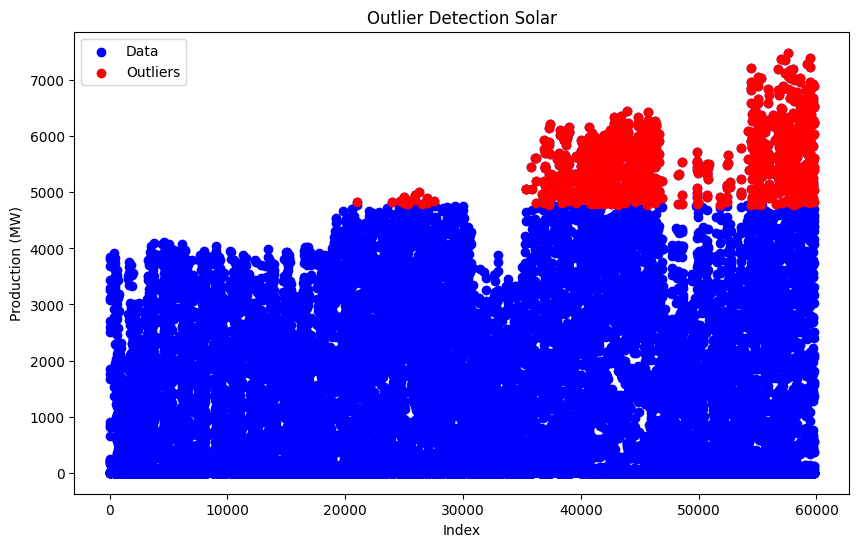

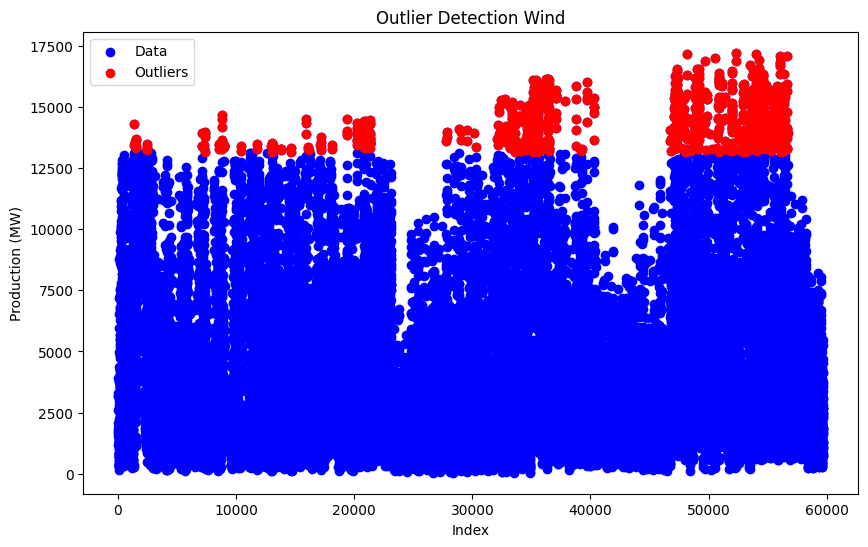

In [593]:
def plot_outliers(df, outliers, name):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['Production'], color='blue', label='Data')
    plt.scatter(outliers.index, outliers['Production'], color='red', label='Outliers')
    plt.xlabel('Index')
    plt.ylabel('Production (MW)')
    plt.title('Outlier Detection ' + str(name))
    plt.legend()
    plt.show()

# Plot outliers for solar data
plot_outliers(df_solar, outliers_solar, 'Solar')

# Plot outliers for wind data
plot_outliers(df_wind, outliers_wind, 'Wind')

#### Observation:
Considering solar and wind power generations are highly correlated with unsteady weather conditions, these outliers are acceptable for ML model training.

## Explority Data Analysis

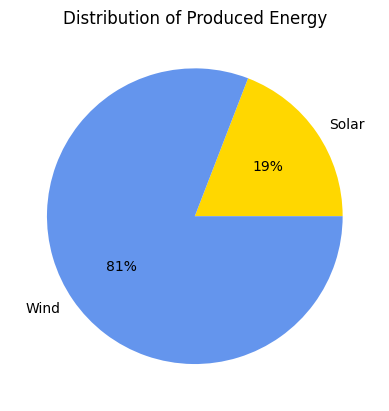

In [594]:
# Wind vs. Solar Energy Production¶
total_production_by_source = df.groupby('Source')['Production'].sum().reset_index()

data = total_production_by_source['Production']
labels = total_production_by_source['Source']
colors = ['#FFD700', '#6495ED']
plt.pie(data, labels=labels, autopct='%.0f%%', colors=colors)
plt.title('Distribution of Produced Energy')
plt.show()

#### Observation:
the data indicates that wind energy production surpasses solar energy production by a significant margin, with wind contributing approximately four times more energy output than solar sources.

This observation is noteworthy within the context of France's renewable energy landscape. Geographical factors, such as France's extensive coastline and inland regions with favorable wind conditions, likely contribute to the prominence of wind energy production. The availability of consistent wind resources across various regions may have facilitated the widespread deployment of wind turbines and the establishment of wind farms, resulting in substantial energy yields.

Additionally, advancements in wind turbine technology, including larger and more efficient turbines, may have further bolstered the competitiveness of wind energy projects in France during this period. These technological improvements, combined with economies of scale in wind farm installations, could have enhanced the cost-effectiveness and overall viability of wind energy relative to solar alternatives.

Moreover, France's energy policy landscape, characterized by supportive regulatory frameworks and ambitious renewable energy targets, likely played a pivotal role in driving the expansion of wind energy capacity. Government initiatives aimed at incentivizing renewable energy investments, such as feed-in tariffs and renewable energy auctions, may have provided impetus for the development of wind power projects across the country.

In contrast, while solar energy production in France has also experienced growth in recent years, its contribution remains comparatively modest compared to wind energy. Factors such as land availability, solar irradiance levels, and the pace of solar infrastructure deployment may have influenced the relative underperformance of solar energy production during this period.

In conclusion, our analysis underscores the dominance of wind energy production over solar alternatives in France between 2020 and 2023. This trend reflects a combination of geographical, technological, and policy factors shaping the country's renewable energy landscape. Understanding these dynamics is crucial for policymakers and industry stakeholders to continue driving the transition towards a sustainable and resilient energy future in France.

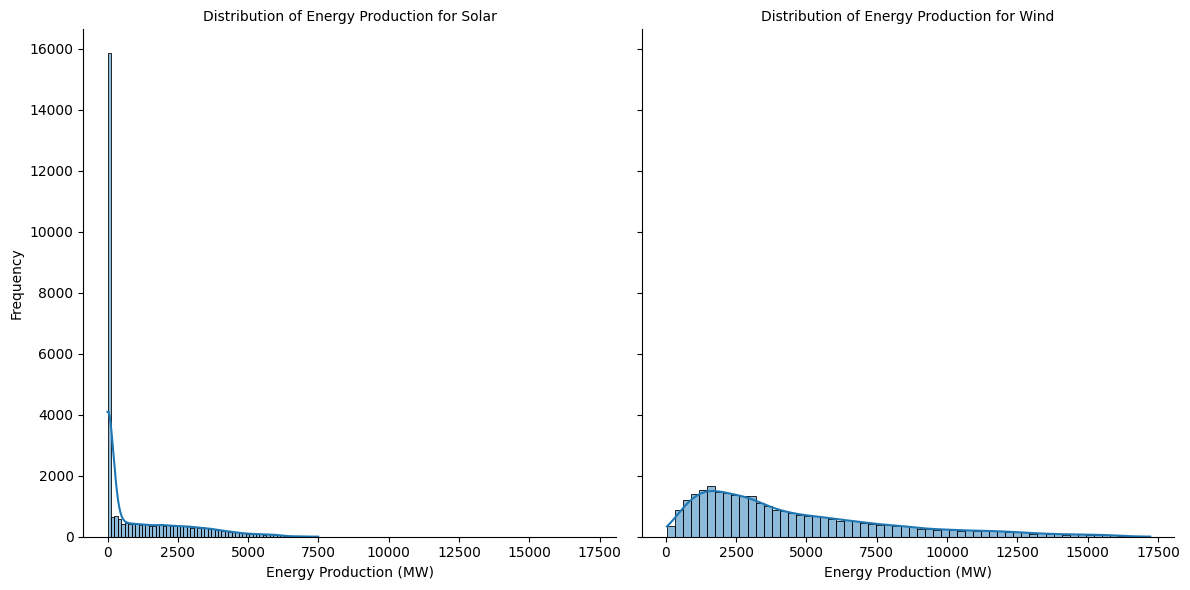

In [595]:
# Check the basic statistics of the 'Production' variable
# Create a FacetGrid for each energy source
g = sns.FacetGrid(df, col="Source", col_wrap=2, height=6)
g.map(sns.histplot, "Production", kde=True)
# Set titles and labels
g.set_titles("Distribution of Energy Production for {col_name}")
g.set_xlabels("Energy Production (MW)")
g.set_ylabels("Frequency")

plt.show()

#### Observation:
- Solar Energy Production:

We observe a significant spike in frequency at the lower end of energy production (around 0-10 MW).
This suggests that most of the solar energy produced in France during this period is concentrated at lower levels.

- Wind Energy Production:

Unlike solar, wind energy distribution is more evenly spread across a range of values.
There is a noticeable peak around the lower end (0-10 MW), but wind energy production extends to higher levels as well.

In summary, France’s solar energy production is heavily skewed toward lower levels, while wind energy production shows a broader distribution across various energy production levels. These observations highlight the differing characteristics of solar and wind energy sources in France during this period

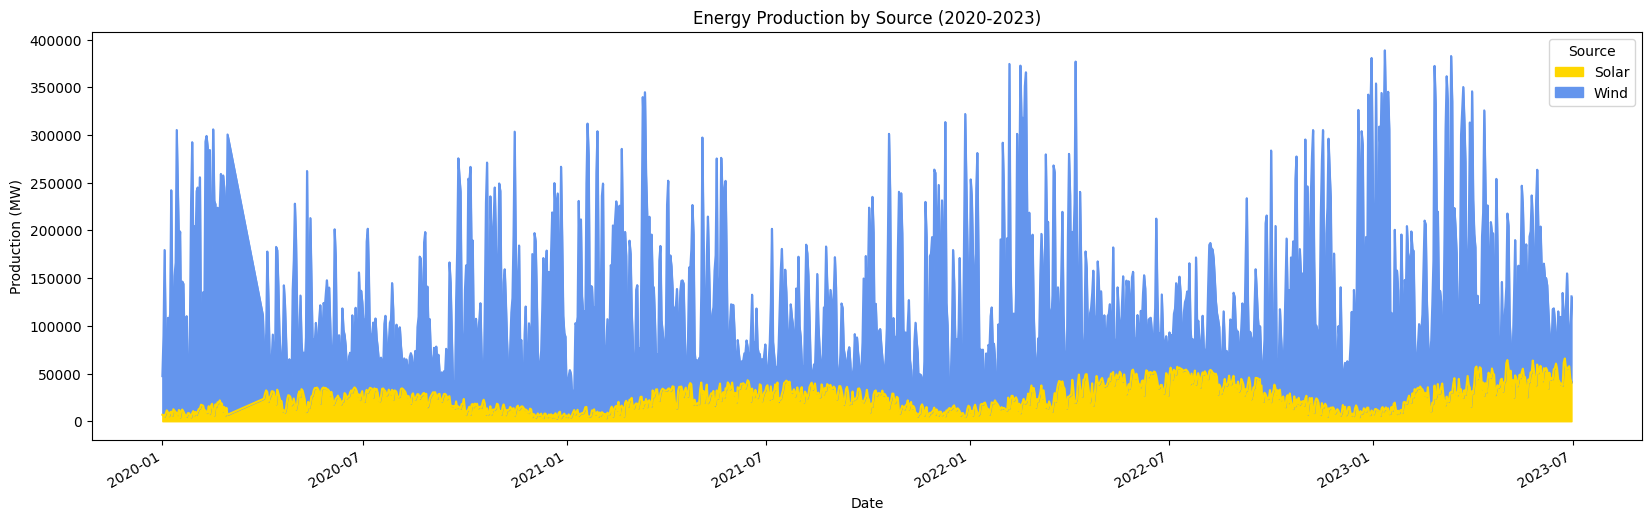

In [596]:
# Daily energy production

daily_avg_production = df.groupby(['Date', 'Source'])['Production'].sum().reset_index()
pivot_df = daily_avg_production.pivot(index='Date', columns='Source', values='Production')
fig, ax = plt.subplots(figsize=(20, 6))
colors = {'Wind': '#6495ED', 'Solar': '#FFD700'}
pivot_df.plot.area(ax=ax, stacked=True, color=colors)
ax.set_xlabel('Date')
ax.set_ylabel('Production (MW)')
ax.set_title('Energy Production by Source (2020-2023)')

plt.show()

It seems that the data for March 2020 for both wind and solar is missing, the plot seems strange!!

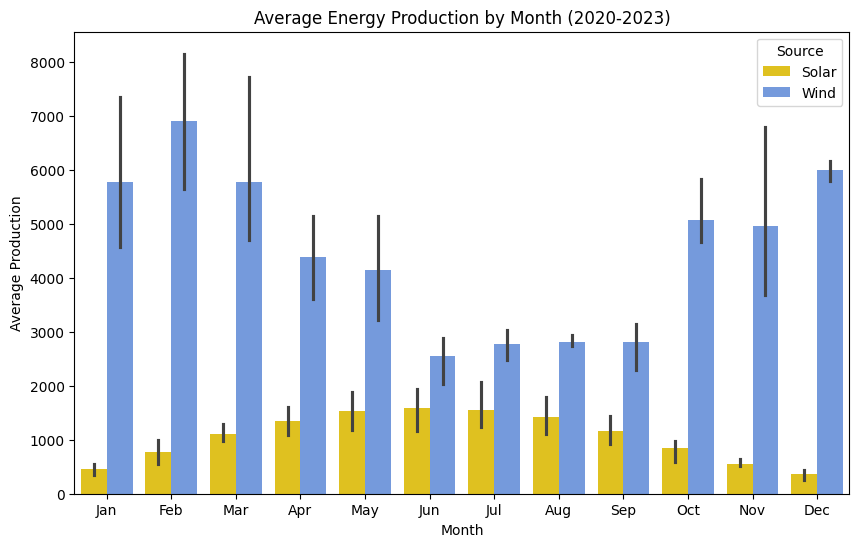

In [597]:
# Average Energy Production by Month
monthly_avg_production = df.groupby(['Year', 'Month', 'Source'])['Production'].mean().reset_index()
# Define the months as labels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = {'Wind': '#6495ED', 'Solar': '#FFD700'}
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=monthly_avg_production, x='Month', y='Production', hue='Source', palette=colors)
plt.xlabel('Month')
plt.ylabel('Average Production')
plt.title('Average Energy Production by Month (2020-2023)')
plt.xticks(np.linspace(0,11,12),labels=months)
plt.show()

#### Observation based on last 2 plots:
- Solar Energy Production:

During the summer months (May to August), which coincide with the sunniest days, there is a consistent upward trend in solar energy production.
The peak solar energy production occurs during these months, indicating that solar panels are most effective when exposed to abundant sunlight.

- Wind Energy Production:

For wind energy, the peaks occur during the months of January, February, March and December.
These months correspond to a period when wind conditions are favorable for harnessing wind energy.
Wind turbines generate more power during this time due to increased wind speeds.

In summary, solar energy production follows a seasonal pattern, peaking in summer, while wind energy production has its highest points in early spring

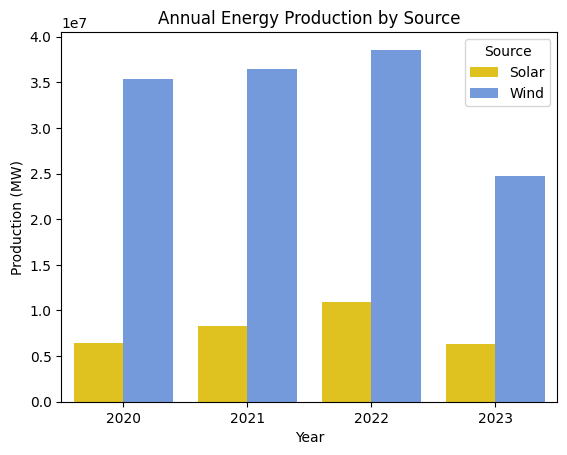

In [598]:
# Annual Energy Production
annual_production = df.groupby(by=['Source', 'Year'])['Production'].sum().reset_index()
colors = {'Wind': '#6495ED', 'Solar': '#FFD700'}
sns.barplot(data=annual_production, x='Year', y='Production', hue='Source', palette=colors)
plt.title('Annual Energy Production by Source')
plt.xlabel('Year')
plt.ylabel('Production (MW)')
plt.legend(title='Source')

plt.show()

#### Observation:

Based on the plot above, we conclude that the source of a large proportion of renewable energy produced yearly is mainly wind. Also, we can observe a positive energy production rate in both sources as years pass.

Note: the second half of the year 2023 hasn't arrived yet, therefor it hasn't been recorded yet.

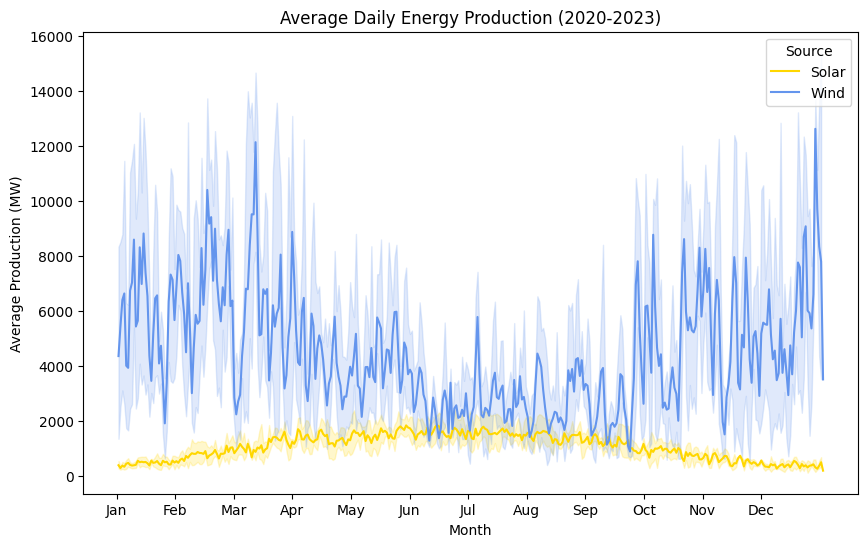

In [599]:
# Average Daily Prodcution Over Year
daily_avg_production = df.groupby(['Year', 'dayOfYear', 'Source'])['Production'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'Wind': '#6495ED', 'Solar': '#FFD700'}
sns.lineplot(data=daily_avg_production, x='dayOfYear', y='Production', hue='Source', palette=colors)
plt.xlabel('Month')
plt.ylabel('Average Production (MW)')
plt.title('Average Daily Energy Production (2020-2023)')
plt.xticks(np.linspace(0,334,12),labels=months)
plt.show()

#### Observation:

- Solar Energy Production:

The solar energy production line (in yellow) remains relatively constant throughout the year.
It hovers around an average of 2000 MW.

- Wind Energy Production:

The wind energy production line (in blue) shows substantial variability.

January and February: Wind energy production peaks, reaching close to 16000 MW.

March and April: Another peak occurs during these months.

June to August: Wind energy production remains relatively high.

September to December: Wind energy production experiences fluctuations but generally stays above 4000 MW.

In summary, wind energy production dominates, with pronounced peaks during specific months, while solar energy production maintains a steady level. The variability in wind energy aligns with seasonal patterns and favorable wind conditions.

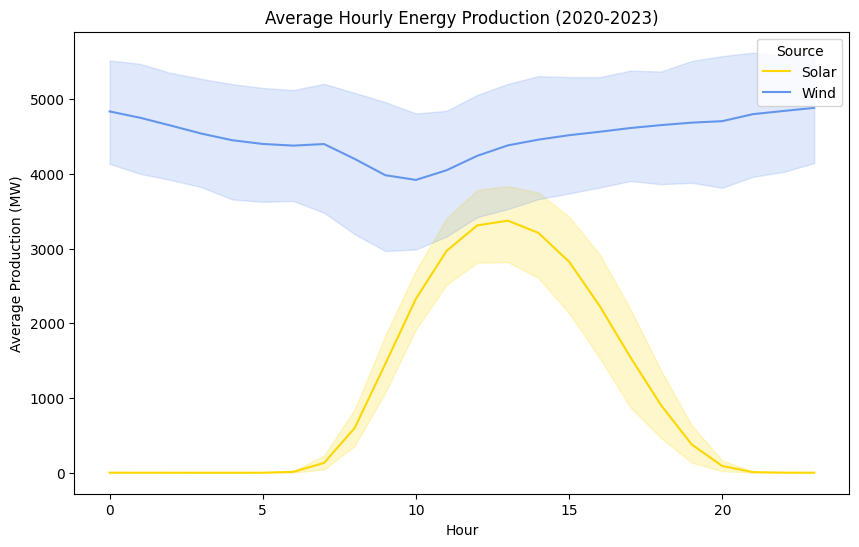

In [600]:
# Energy produced on Average through a day

# df['Hour'] = pd.to_datetime(df['StartHour'], format='%H:%M:%S').dt.hour
hourly_avg_production = df.groupby(['StartHour', 'Month', 'Source'])['Production'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'Wind': '#6495ED', 'Solar': '#FFD700'}
sns.lineplot(data=hourly_avg_production, x='StartHour', y='Production', hue='Source', palette=colors)
plt.xlabel('Hour')
plt.ylabel('Average Production (MW)')
plt.title('Average Hourly Energy Production (2020-2023)')
plt.show()

#### Observation:
- Solar Energy Production:

Solar energy production exhibits a clear diurnal pattern.

During daylight hours (approximately from hour 7 to hour 13), solar energy production increases significantly.

The peak occurs around hour 13, reaching more than 3000 MW.
After sunset (hour 15), solar energy production sharply decreases.

- Wind Energy Production:

Wind energy production remains relatively consistent throughout the day.

It fluctuates between approximately 4000 MW and 4800 MW.

Unlike solar, wind energy does not show a strong dependence on time of day.

In summary, solar energy production follows the availability of sunlight, peaking during midday hours, while wind energy maintains a steadier output.

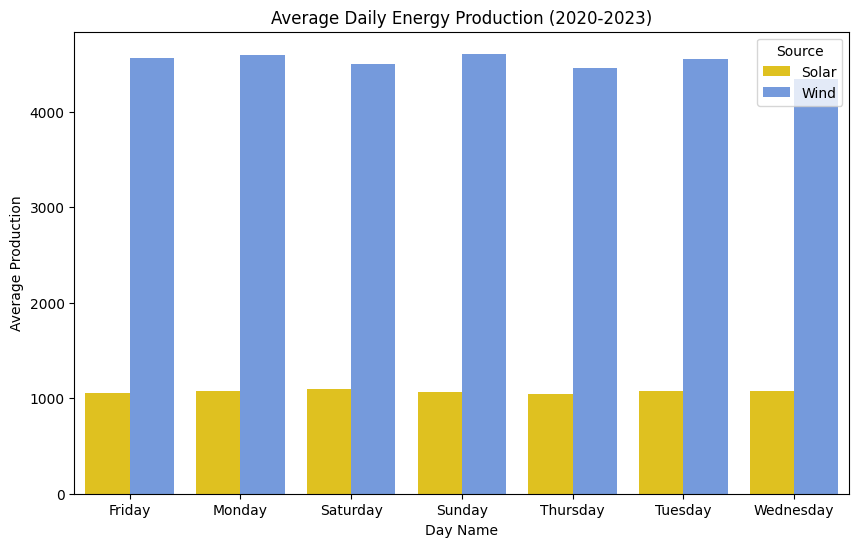

In [601]:
# It seems that the day of week should have no effect on the production, but to be sure, we examine that.
daily_avg_production_by_week_day = df.groupby(['dayName', 'Source'])['Production'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'Wind': '#6495ED', 'Solar': '#FFD700'}
sns.barplot(data=daily_avg_production_by_week_day, x='dayName', y='Production', hue='Source', palette=colors)
plt.xlabel('Day Name')
plt.ylabel('Average Production')
plt.title('Average Daily Energy Production (2020-2023)')
plt.show()

#### Observation:
There is not any significant pattern for the day of the week, therefor we can drop the column.

In [602]:
# Label encoding
df.drop(['Time Interval'], axis=1, inplace=True)
df_corr=df.copy()
le=LabelEncoder()
lst=['Source','dayName']
for i in lst:
    df_corr[i]=le.fit_transform(df_corr[i])
df_corr.head()

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,Year,Month,Day
0,2020-07-22,20,21,0,244.0,204,6,2020,7,22
1,2020-07-23,7,8,0,223.0,205,4,2020,7,23
2,2020-07-23,16,17,0,2517.0,205,4,2020,7,23
3,2020-07-23,19,20,0,658.0,205,4,2020,7,23
4,2020-07-23,23,24,0,0.0,205,4,2020,7,23


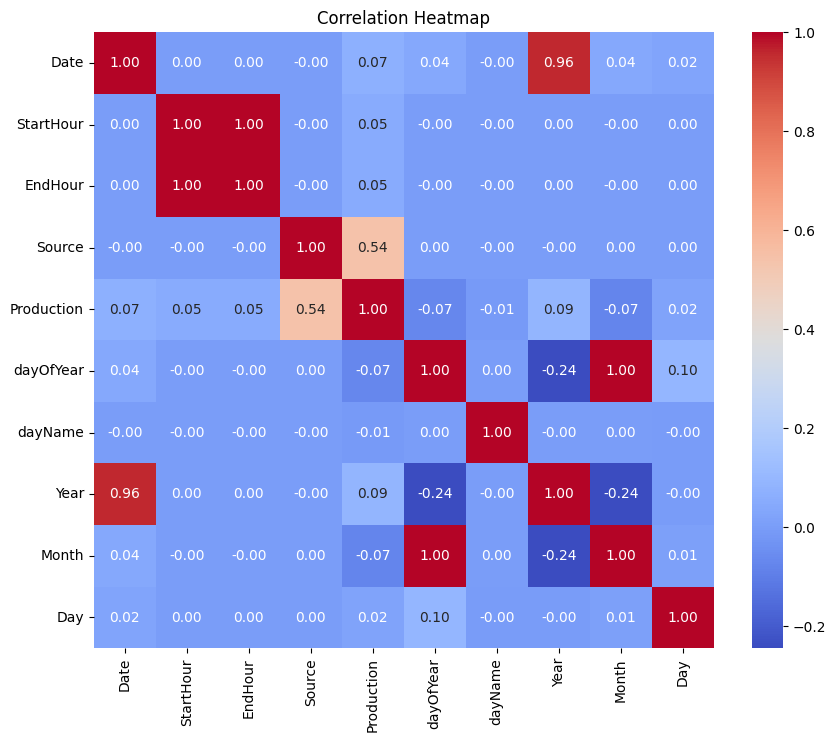

In [603]:
# Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

#### Observation
Now we can confirm our idea that dayName (day of week) has no effect on Production and we can drop it

In [604]:
# Dropping unneccessary columns
df.drop(['dayName'], axis=1, inplace=True)

## ML

In [605]:
df

,Date,StartHour,EndHour,Source,Production,dayOfYear,Year,Month,Day
0,2020-07-22,20,21,Solar,244.0,204,2020,7,22
1,2020-07-23,7,8,Solar,223.0,205,2020,7,23
2,2020-07-23,16,17,Solar,2517.0,205,2020,7,23
3,2020-07-23,19,20,Solar,658.0,205,2020,7,23
4,2020-07-23,23,24,Solar,0.0,205,2020,7,23
...,...,...,...,...,...,...,...,...,...
59801,2023-06-30,6,7,Solar,55.0,181,2023,6,30
59802,2023-06-30,13,14,Solar,4554.0,181,2023,6,30
59803,2023-06-30,14,15,Solar,4589.0,181,2023,6,30
59804,2023-06-30,16,17,Solar,4173.0,181,2023,6,30


In [606]:
# Create a copy of df with data related to solar
df_solar = df[df['Source'] == 'Solar'].copy()
# Create a copy of df with data related to wind
df_wind = df[df['Source'] == 'Wind'].copy()

In [607]:
# Define features and target
def split_features_target(data):
    
    features = data.drop(columns=['Date', 'Source', 'Production']).to_numpy()
    target = data['Production'].to_numpy()
    
    return features, target
    
features_solar, target_solar = split_features_target(df_solar)
features_wind, target_wind = split_features_target(df_wind)

In [608]:
# Data Scaling
scaler = MinMaxScaler()

scaled_features_solar = scaler.fit_transform(features_solar)
target_solar = target_solar.reshape((-1, 1))
scaled_target_solar = scaler.fit_transform(target_solar)

scaled_features_wind = scaler.fit_transform(features_wind)
target_wind = target_wind.reshape((-1, 1))
scaled_target_wind = scaler.fit_transform(target_wind)

print('The shape of features in the solar dataset:', features_solar.shape)
print('The shape of target in the solar dataset:', target_solar.shape)
print('The shape of features in the wind dataset:', features_wind.shape)
print('The shape of target in the wind dataset:', target_wind.shape)

The shape of features in the solar dataset: (29901, 6)
The shape of target in the solar dataset: (29901, 1)
The shape of features in the wind dataset: (29903, 6)
The shape of target in the wind dataset: (29903, 1)


In [609]:
# Training/testing split

X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(features_solar, target_solar, test_size=0.2,
                                                                           random_state=7, shuffle=False)
y_train_solar = y_train_solar.reshape(-1)
y_test_solar = y_test_solar.reshape(-1)

X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(features_wind, target_wind, test_size=0.2,
                                                                           random_state=11, shuffle=False)
y_train_wind = y_train_wind.reshape(-1)
y_test_wind = y_test_wind.reshape(-1)

print('X_train_solar shape:', X_train_solar.shape)
print('y_train_solar shape:', y_train_solar.shape)
print('X_test_solar shape:', X_test_solar.shape)
print('y_test_solar shape:', y_test_solar.shape)
print('X_train_wind shape:', X_train_wind.shape)
print('y_train_wind shape:', y_train_wind.shape)
print('X_test_wind shape:', X_test_wind.shape)
print('y_test_wind shape:', y_test_wind.shape)

X_train_solar shape: (23920, 6)
y_train_solar shape: (23920,)
X_test_solar shape: (5981, 6)
y_test_solar shape: (5981,)
X_train_wind shape: (23922, 6)
y_train_wind shape: (23922,)
X_test_wind shape: (5981, 6)
y_test_wind shape: (5981,)


In [610]:
df.dtypes

Date          datetime64[ns]
StartHour              int64
EndHour                int64
Source                object
Production           float64
dayOfYear              int64
Year                   int32
Month                  int32
Day                    int32
dtype: object

### Linear regression 

In [611]:
# Initialize models for Solar
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor()
}

# Evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train_solar, y_train_solar)
    y_pred = model.predict(X_test_solar)
    results[model_name] = {
        'MAE': mean_absolute_error(y_test_solar, y_pred),
        'MSE': mean_squared_error(y_test_solar, y_pred),
        'RMSE': mean_squared_error(y_test_solar, y_pred, squared=False),
        'R2': r2_score(y_test_solar, y_pred)
    }

# Create DataFrame from results
df_results = pd.DataFrame(results)

# Print summary table
print(df_results)


      Linear Regression  Random Forest  Gradient Boosting       AdaBoost  \
MAE        1.454719e+03     355.025924         430.507360     571.687665   
MSE        3.124573e+06  555546.889494      498909.311692  657887.617131   
RMSE       1.767646e+03     745.350179         706.335127     811.102717   
R2         5.954812e-02       0.832788           0.849835       0.801985   

            XGBoost  
MAE      389.353062  
MSE   553222.769108  
RMSE     743.789466  
R2         0.833488  


#### Observation: 
Random Forest, Gradient Boosting, and XGBoost models outperform Linear Regression and AdaBoost models for solar energy forecasting, as they have lower error metrics and higher R2 scores, indicating better predictive performance. Among them, Random Forest and XGBoost models seem to perform slightly better.

In [612]:
# Initialize models for wind
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor()
}

# Evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train_wind, y_train_wind)
    y_pred = model.predict(X_test_wind)
    results[model_name] = {
        'MAE': mean_absolute_error(y_test_wind, y_pred),
        'MSE': mean_squared_error(y_test_wind, y_pred),
        'RMSE': mean_squared_error(y_test_wind, y_pred, squared=False),
        'R2': r2_score(y_test_wind, y_pred)
    }

# Create DataFrame from results
df_results = pd.DataFrame(results)

# Print summary table
print(df_results)

      Linear Regression  Random Forest  Gradient Boosting      AdaBoost  \
MAE        3.136919e+03   2.639362e+03       3.050803e+03  3.044557e+03   
MSE        1.708696e+07   1.489695e+07       1.498623e+07  1.400572e+07   
RMSE       4.133638e+03   3.859656e+03       3.871206e+03  3.742422e+03   
R2        -1.214504e-01   2.228471e-02       1.642471e-02  8.077769e-02   

           XGBoost  
MAE   2.905827e+03  
MSE   1.612483e+07  
RMSE  4.015573e+03  
R2   -5.830348e-02  


#### Observation:
all models perform poorly for wind energy forecasting, as indicated by the high error metrics and low R2 scores. It suggests that the models are not capturing the underlying patterns and variability in the wind energy data effectively. Further analysis and feature engineering may be needed to improve the performance of the models for wind energy forecasting.

### ARIMA

In [613]:
# Create a copy of df with data related to solar
df_solar_arima = df[df['Source'] == 'Solar'].copy()
df_solar_arima.drop(['Source'], axis=1, inplace=True)
# Create a copy of df with data related to wind
df_wind_arima = df[df['Source'] == 'Wind'].copy()
df_wind_arima.drop(['Source'], axis=1, inplace=True)

In [614]:
df_solar_arima.dtypes

Date          datetime64[ns]
StartHour              int64
EndHour                int64
Production           float64
dayOfYear              int64
Year                   int32
Month                  int32
Day                    int32
dtype: object

In [615]:
# For using Arima we should first be sure taht the data is Stationary. To examine that:
df_solar_arima_test= df_solar_arima[['Production']].copy()
# if the p-value>0.05 we need to find the order of differencing
result=adfuller(df_solar_arima_test.Production.dropna())
print(f"ADF statistics: {result[0]}")
print(f"p-value: {result[1]}")

ADF statistics: -10.917453571360921
p-value: 1.058641443057228e-19


It means that the data is not stationary. So wee need to difffernce it.

In [616]:
from pmdarima.arima.utils import ndiffs
ndiffs(df_solar_arima_test.Production, test="adf")

0

In [617]:
### What does it mean?!! it dosnt need any differencing??

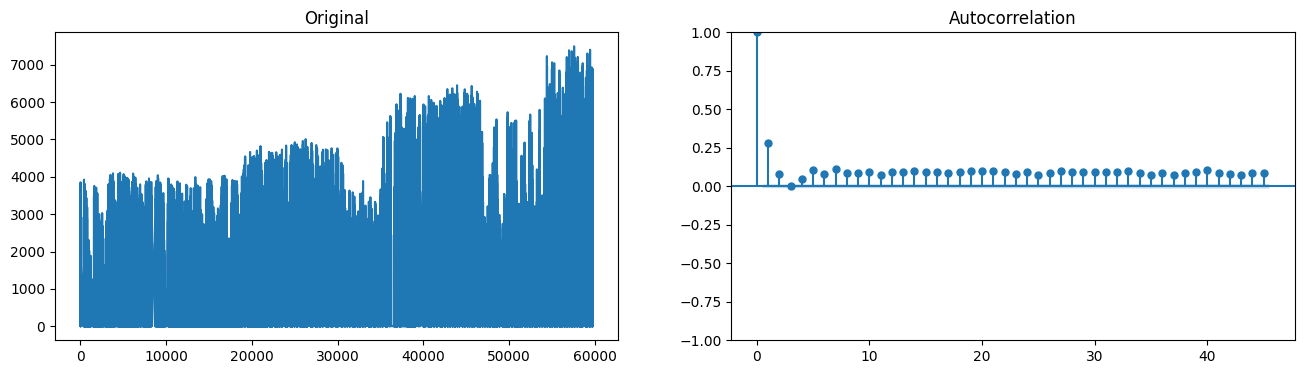

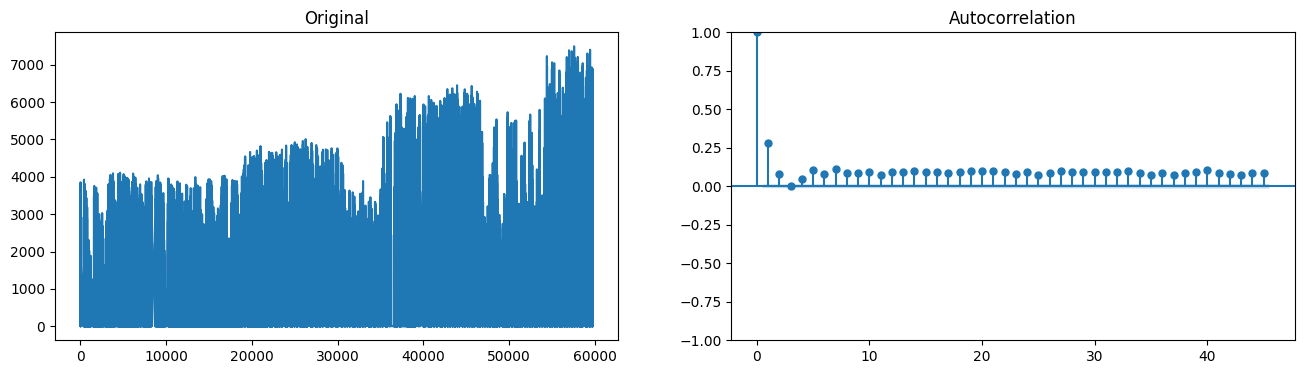

In [618]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(df_solar_arima_test.Production)
ax1.set_title("Original")
plot_acf(df_solar_arima_test.Production, ax=ax2)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89027D+00    |proj g|=  8.26848D-02

At iterate    5    f=  8.82840D+00    |proj g|=  1.15565D-02

At iterate   10    f=  8.82227D+00    |proj g|=  6.64222D-03

At iterate   15    f=  8.82158D+00    |proj g|=  1.31790D-03

At iterate   20    f=  8.82156D+00    |proj g|=  2.36605D-04

At iterate   25    f=  8.81747D+00    |proj g|=  7.73137D-02

At iterate   30    f=  8.72538D+00    |proj g|=  3.73408D-02

At iterate   35    f=  8.72475D+00    |proj g|=  3.96431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

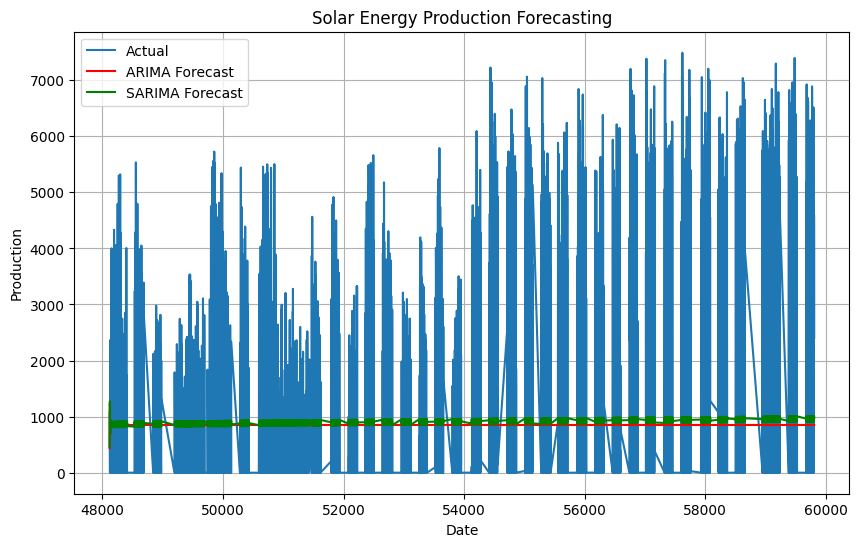

In [619]:
# Split the data into train and test sets
train_size = int(len(df_solar_arima) * 0.8)
train, test = df_solar_arima.iloc[:train_size], df_solar_arima.iloc[train_size:]

# ARIMA Model
def fit_arima(train, test):
    # Fit ARIMA model
    model = ARIMA(train['Production'], order=(5,1,0))  # Example order: ARIMA(5,1,0)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    return forecast

# SARIMA Model
def fit_sarima(train, test):
    # Fit SARIMA model
    model = SARIMAX(train['Production'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Example order: SARIMA(5,1,0)(1,1,1,12)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    return forecast

# Evaluation function
def evaluate_forecast(test, forecast):
    mse = mean_squared_error(test['Production'], forecast)
    rmse = np.sqrt(mse)
    return mse, rmse

# Fit ARIMA model and make forecasts
arima_forecast = fit_arima(train, test)

# Fit SARIMA model and make forecasts
sarima_forecast = fit_sarima(train, test)

# Evaluate forecasts
arima_mse, arima_rmse = evaluate_forecast(test, arima_forecast)
sarima_mse, sarima_rmse = evaluate_forecast(test, sarima_forecast)

# Print evaluation results
print("ARIMA Model Evaluation:")
print("Mean Squared Error (MSE):", arima_mse)
print("Root Mean Squared Error (RMSE):", arima_rmse)
print()
print("SARIMA Model Evaluation:")
print("Mean Squared Error (MSE):", sarima_mse)
print("Root Mean Squared Error (RMSE):", sarima_rmse)

# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Production'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Solar Energy Production Forecasting')
plt.legend()
plt.grid(True)
plt.show()


In [620]:
# wind
# For using Arima we should first be sure taht the data is Stationary. To examine that:
df_wind_arima_test= df_wind_arima[['Production']].copy()
# if the p-value>0.05 we need to find the order of differencing
result=adfuller(df_wind_arima_test.Production.dropna())
print(f"ADF statistics: {result[0]}")
print(f"p-value: {result[1]}")

ADF statistics: -14.853835244772043
p-value: 1.7605966116015526e-27


It means that the data is not stationary. So wee need to difffernce it.

In [621]:
ndiffs(df_wind_arima_test.Production, test="adf")

0

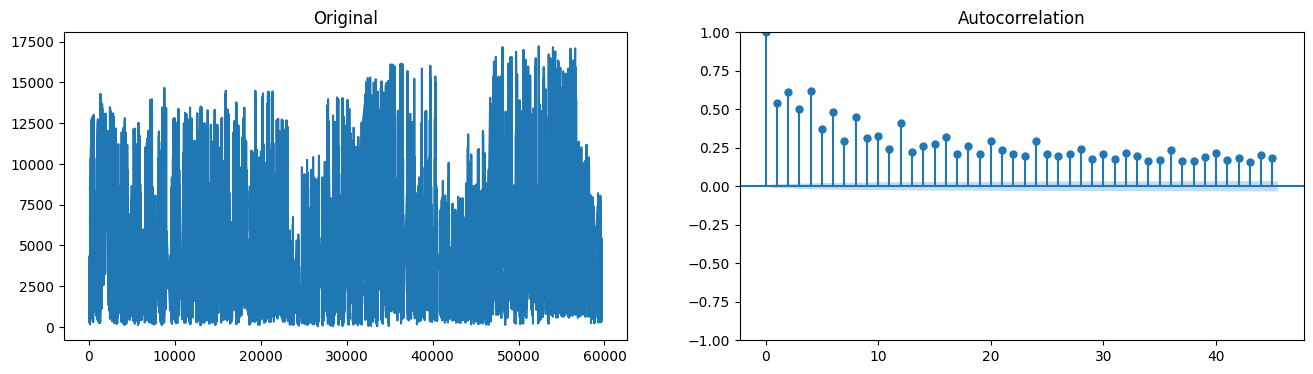

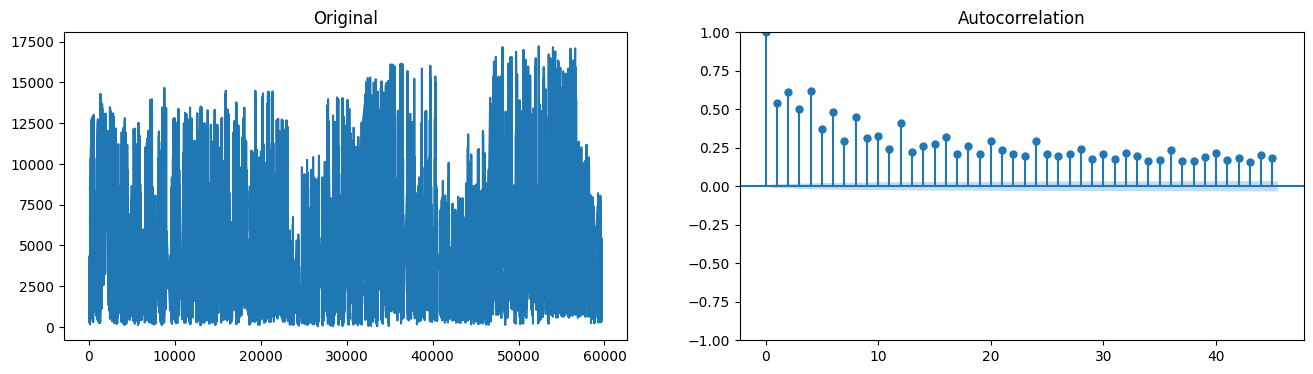

In [622]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(df_wind_arima_test.Production)
ax1.set_title("Original")
plot_acf(df_wind_arima_test.Production, ax=ax2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31628D+00    |proj g|=  1.09514D-01


 This problem is unconstrained.



At iterate    5    f=  9.25494D+00    |proj g|=  1.37344D-02

At iterate   10    f=  9.25052D+00    |proj g|=  3.72426D-03

At iterate   15    f=  9.25015D+00    |proj g|=  1.98728D-04

At iterate   20    f=  9.25015D+00    |proj g|=  9.25417D-04

At iterate   25    f=  9.24970D+00    |proj g|=  1.16133D-02

At iterate   30    f=  9.21247D+00    |proj g|=  1.00699D-01

At iterate   35    f=  9.20336D+00    |proj g|=  1.26043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     43      1     0     0   1.637D-05   9.203D+00
  F =   9.2033562964840705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

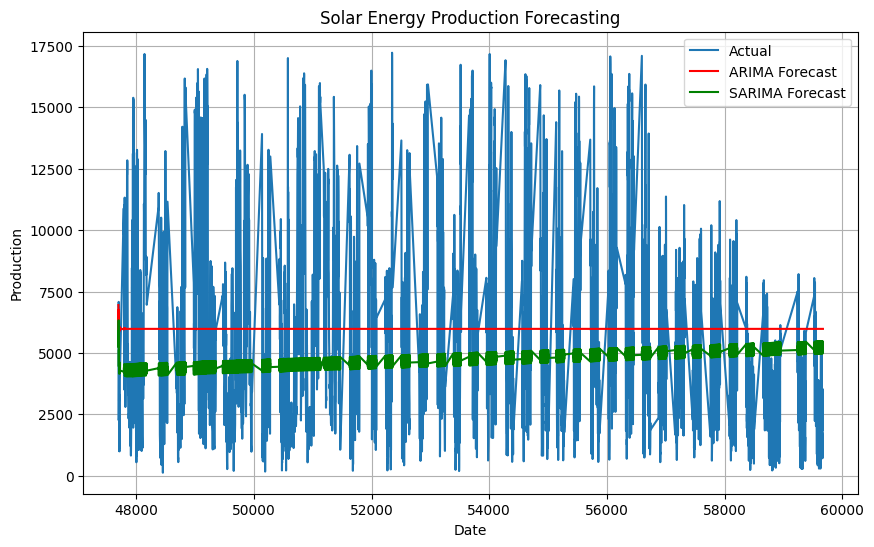

In [623]:
# Split the data into train and test sets
train_size = int(len(df_wind_arima) * 0.8)
train, test = df_wind_arima.iloc[:train_size], df_wind_arima.iloc[train_size:]

# ARIMA Model
def fit_arima(train, test):
    # Fit ARIMA model
    model = ARIMA(train['Production'], order=(5,1,0))  # Example order: ARIMA(5,1,0)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    return forecast

# SARIMA Model
def fit_sarima(train, test):
    # Fit SARIMA model
    model = SARIMAX(train['Production'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Example order: SARIMA(5,1,0)(1,1,1,12)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    return forecast

# Evaluation function
def evaluate_forecast(test, forecast):
    mse = mean_squared_error(test['Production'], forecast)
    rmse = np.sqrt(mse)
    return mse, rmse

# Fit ARIMA model and make forecasts
arima_forecast = fit_arima(train, test)

# Fit SARIMA model and make forecasts
sarima_forecast = fit_sarima(train, test)

# Evaluate forecasts
arima_mse, arima_rmse = evaluate_forecast(test, arima_forecast)
sarima_mse, sarima_rmse = evaluate_forecast(test, sarima_forecast)

# Print evaluation results
print("ARIMA Model Evaluation:")
print("Mean Squared Error (MSE):", arima_mse)
print("Root Mean Squared Error (RMSE):", arima_rmse)
print()
print("SARIMA Model Evaluation:")
print("Mean Squared Error (MSE):", sarima_mse)
print("Root Mean Squared Error (RMSE):", sarima_rmse)

# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Production'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Solar Energy Production Forecasting')
plt.legend()
plt.grid(True)
plt.show()


### LSTM

In [624]:
# cutting January and February 2020 values from the whole data
daily_production = df.groupby(by=["Source","Date"]).Production.sum().reset_index()
daily_production["Date"] = pd.to_datetime(daily_production["Date"])

In [625]:
# cutting January and February 2020 values from the whole data
cuted_daily_production = daily_production[daily_production.Date >= "2020-04-01"]
cuted_daily_production.set_index("Date", inplace=True, drop=True)

In [626]:
test_size = 150 # Predicting the last "test_size" values

# MinMaxScalers for scaling the production values into the [0, 1] range
Solar_scaler = MinMaxScaler(feature_range=(0, 1))
Wind_scaler = MinMaxScaler(feature_range=(0, 1))

# fitting the Scalers to the WHOLE data (including January and February 2020)
Solar_scaler.fit(daily_production[daily_production.Source == "Solar"][-test_size::-1].Production.values.reshape(-1, 1))
Wind_scaler.fit(daily_production[daily_production.Source == "Wind"][-test_size::-1].Production.values.reshape(-1, 1))

# Transforming the cuted data
Solar_data = Solar_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Solar"][-test_size::-1].Production.values.reshape(-1, 1))
Wind_data = Wind_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Wind"][-test_size::-1].Production.values.reshape(-1, 1))

In [627]:
# A function for creating dataset for the model to work with
# returns "X" of shape (num_batch, x_batch_size, 1), "y" of shape (num_batch, y_batch_size, 1)
def create_dataset(target, x_size, y_size):
    X = []
    y = []
    
    x_start = 0
    x_end = x_start + x_size
    y_start = x_end
    y_end = y_start + y_size
    
    for _ in range(len(target)):
        if y_end < len(target):
            X.append(target[x_start:x_end])
            y.append(target[y_start:y_end])
        
        x_start += 1
        x_end = x_start + x_size
        y_start += 1
        y_end = y_start + y_size
    
    return np.array(X), np.array(y)

In [628]:
x_size = 30
y_size = 4
Solar_x, Solar_y = create_dataset(Solar_data, x_size, y_size)
Wind_x, Wind_y = create_dataset(Wind_data, x_size, y_size)

In [629]:
Solar_y = Solar_y.reshape(Solar_y.shape[0], Solar_y.shape[1])
Wind_y = Wind_y.reshape(Wind_y.shape[0], Wind_y.shape[1])

Solar_x.shape, Solar_y.shape, Wind_x.shape, Wind_y.shape

((1003, 30, 1), (1003, 4), (1003, 30, 1), (1003, 4))

In [630]:
# A function for creating LSTM model
def create_LSTM_model(x_size, y_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((x_size, 1)),
        tf.keras.layers.LSTM(512),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(y_size, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

In [631]:
# custom log printer for printing log lines every 50 epoch
class PrintLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, logpath):
        self.logpath = logpath
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {np.round(logs["loss"], 5)} | Accuracy = {np.round(logs["accuracy"], 5)}')
            
log_path = "/Users/moni/DS - Karan/Week6/log.txt"
callbacks=[PrintLossCallback(log_path)]

In [632]:
Solar_model = create_LSTM_model(x_size, y_size)
Solar_model.fit(x=Solar_x, y=Solar_y, epochs=600, batch_size=8, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.02696 | Accuracy = 0.2682
Epoch 50: Loss = 0.01252 | Accuracy = 0.31107
Epoch 100: Loss = 0.00734 | Accuracy = 0.39781
Epoch 150: Loss = 0.00552 | Accuracy = 0.49252
Epoch 200: Loss = 0.0031 | Accuracy = 0.58824
Epoch 250: Loss = 0.00221 | Accuracy = 0.67597
Epoch 300: Loss = 0.00164 | Accuracy = 0.70588
Epoch 350: Loss = 0.00129 | Accuracy = 0.71486
Epoch 400: Loss = 0.00141 | Accuracy = 0.71884
Epoch 450: Loss = 0.00101 | Accuracy = 0.7996
Epoch 500: Loss = 0.00103 | Accuracy = 0.77069
Epoch 550: Loss = 0.00089 | Accuracy = 0.77567


In [633]:
Wind_model = create_LSTM_model(x_size, y_size)
Wind_model.fit(x=Wind_x, y=Wind_y, epochs=400, batch_size=8, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.04339 | Accuracy = 0.25723
Epoch 50: Loss = 0.02196 | Accuracy = 0.40977
Epoch 100: Loss = 0.00678 | Accuracy = 0.57827
Epoch 150: Loss = 0.00317 | Accuracy = 0.71984
Epoch 200: Loss = 0.00222 | Accuracy = 0.78465
Epoch 250: Loss = 0.00164 | Accuracy = 0.7986
Epoch 300: Loss = 0.00115 | Accuracy = 0.82951
Epoch 350: Loss = 0.00106 | Accuracy = 0.83151


In [634]:
# Testing phase
Solar_test = Solar_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Solar"][-test_size:-1].Production.values.reshape(-1, 1))
Wind_test = Wind_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Wind"][-test_size:-1].Production.values.reshape(-1, 1))
Solar_test_x, Solar_test_y = create_dataset(Solar_test, x_size, y_size)
Wind_test_x, Wind_test_y = create_dataset(Wind_test, x_size, y_size)

In [635]:
Solar_test_pred = Solar_model.predict(Solar_test_x)
Wind_test_pred = Wind_model.predict(Wind_test_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [636]:
Solar_test_pred = Solar_scaler.inverse_transform(Solar_test_pred)
Wind_test_pred = Wind_scaler.inverse_transform(Wind_test_pred)

In [637]:
# Creating data frames from the predicted values for plotting conveniency
df_solar_pred = pd.DataFrame(columns=["Date", "Production"])
df_solar_pred.Date = cuted_daily_production[cuted_daily_production.Source == "Solar"][-len(Solar_test_pred)::+1].index
df_solar_pred.Production = Solar_test_pred[:, 0]
df_solar_pred["Date"] = pd.to_datetime(df_solar_pred["Date"])

df_wind_pred = pd.DataFrame(columns=["Date", "Production"])
df_wind_pred.Date = cuted_daily_production[cuted_daily_production.Source == "Wind"][-len(Wind_test_pred)::+1].index
df_wind_pred.Production = Wind_test_pred[:, 0]
df_wind_pred["Date"] = pd.to_datetime(df_wind_pred["Date"])

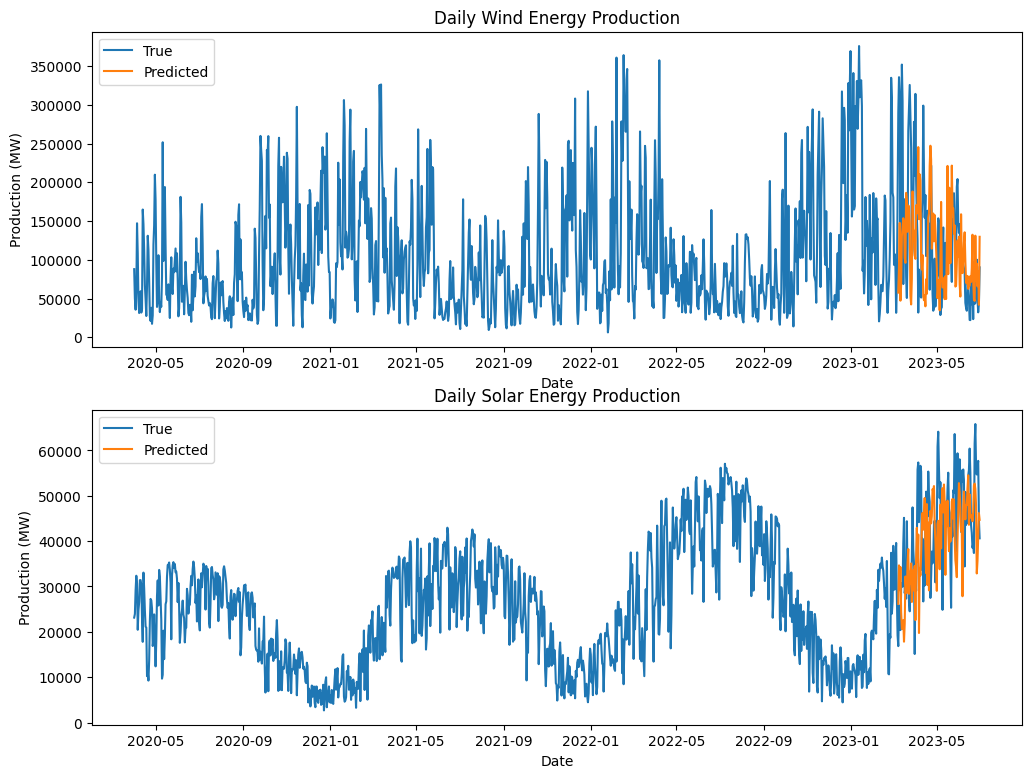

In [638]:
# plotting the results
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 2)

plt.subplot(2, 1, 1)
plt.title("Daily Wind Energy Production")
sns.lineplot(data=cuted_daily_production[cuted_daily_production.Source=="Wind"],
             x="Date", y="Production", label="True")
sns.lineplot(data=df_wind_pred, x="Date", y="Production", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.subplot(2, 1, 2)
plt.title("Daily Solar Energy Production")
sns.lineplot(data=cuted_daily_production[cuted_daily_production.Source=="Solar"],
             x="Date", y="Production", label="True")
sns.lineplot(data=df_solar_pred, x="Date", y="Production", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.show()

It shows that the modelling with LSTM works fine with both solar and wind energy oriduction forcasting.